## ml-mipt course

### Seminar 2
### Linear Regression & other stuff

Based on [Evgeny Sokolov](https://github.com/esokolov) open materials.

Let's take a look at Linear Regression and its implementations in this notebook.

__Contents__:
* Linear Regression analytical solution
* Gradient descent approach
* Stochastic gradient
* Linear Regression out of the box (sklearn, vw, etc.)
* MSE and MAE in Linear Regression

See `week02_extra*` notebooks for extra (more complex or just additional) materials.

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(16)

matplotlib.rcParams.update({'font.size': 16})

Time to generate features matrix $X$ and correct weights vector $w_{true}$. Targer vector $Y$ is computed as  $Xw_{true}$ with gaussian noise:

In [15]:
n_features = 2
n_objects = 300
batch_size = 10
#for gradient descent
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

*Recap:*
Analytical solution formula is simple:

$$
w = (X^TX)^{-1}X^Ty.
$$

Let's check how it works:

In [16]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [17]:
w_star

array([ 1.46762288, -1.46285465])

In [18]:
w_true

array([ 1.51026042, -1.4633385 ])

As we can see, the analytical solution is quite close to the original one. 

## Градиентный спуск


Здесь присутствует обращение матрицы $X^TX$ — очень трудоёмкая операция при большом количестве признаков. Нетрудно подсчитать, что сложность вычислений $O(d^3 + d^2l)$. При решении задач такая трудоёмкость часто оказывается непозволительной, поэтому параметры ищут итерационными методами, стоимость которых меньше. Один из них — градиентный спуск.

Напомним, что в градиентном спуске значения параметров на следующем шаге получаются из значений параметров на текущем шаге смещением в сторону антиградиента функционала: 

$$w^{(t+1)} = w^{(t)} - \eta_t \nabla Q(w^{(t)}),$$
где $\eta_t$ — длина шага градиентного спуска.

Формула градиента функции ошибки в случае MSE выглядит следующим образом:

$$\nabla Q(w) = -2X^Ty + 2X^TXw = 2X^T(Xw - y).$$
 
Сложность вычислений в данном случае $O(dl)$. Стохастический градиентный спуск отличается от обычного заменой градиента на несмещённую оценку по одному или нескольким объектам. В этом случае сложность становится $O(kd)$, где $k$ — количество объектов, по которым оценивается градиент, $k << l$. Это отчасти объясняет популярность стохастических методов оптимизации.

### Визуализация траекторий GD и SGD
На простом примере разберём основные тонкости, связанные со стохастической оптимизацией.

Обучим на сгенерированных данных линейную регрессию для MSE при помощи полного градиентного спуска — тем самым получим вектор параметров.

Покажем последовательность оценок параметров $w^{(t)}$, получаемых в ходе итераций. Красная точка — $w_{true}$.

In [44]:
w_0 = np.random.uniform(-2, 2, n_features)
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.size
    w_list.append(w.copy())
w_list = np.array(w_list)

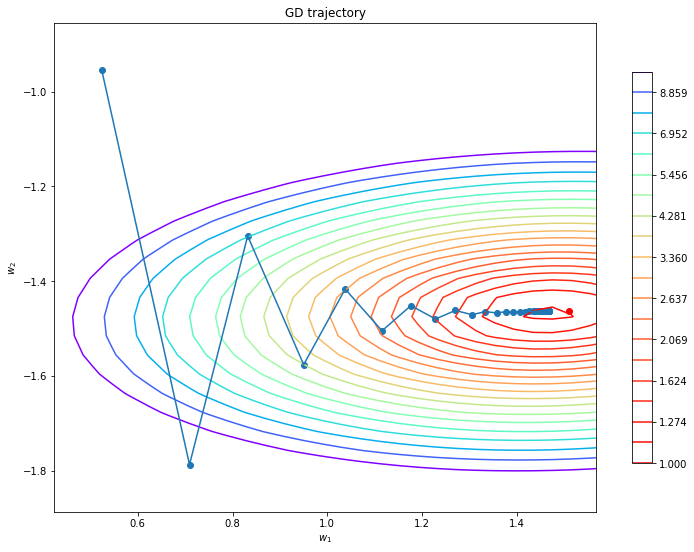

In [39]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Градиент перпендикулярен линиям уровня. Это объясняет такие зигзагообразные траектории градиентного спуска. Для большей наглядности в каждой точке пространства посчитаем градиент функционала и покажем его направление.

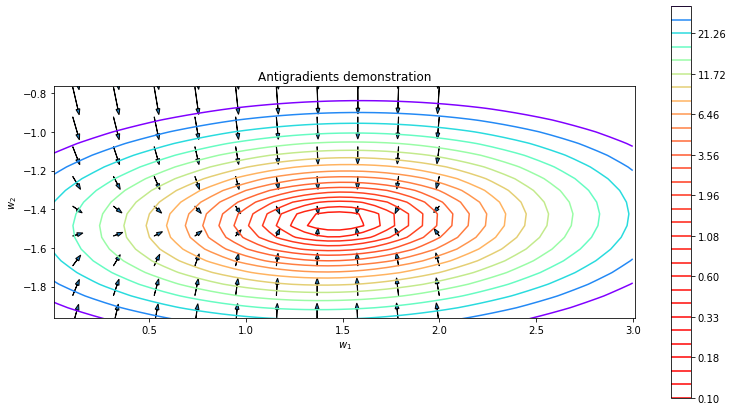

In [40]:
# compute level set
A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
A_mini, B_mini = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 27))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
        
# visualize the level set
plt.figure(figsize=(13, 9))
CS = plt.contour(A, B, levels, levels=np.logspace(-1, 1.5, num=30), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
        
# visualize the gradients
gradients = np.empty_like(A_mini)
for i in range(A_mini.shape[0]):
    for j in range(A_mini.shape[1]):
        w_tmp = np.array([A_mini[i, j], B_mini[i, j]])
        antigrad = - 2 * 1e-3 * np.dot(X.T, np.dot(X, w_tmp) - Y) / Y.shape[0]
        plt.arrow(A_mini[i, j], B_mini[i, j], antigrad[0], antigrad[1], head_width=0.02)

plt.title('Antigradients demonstration')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_true[0] - 1.5, w_true[0] + 1.5))
plt.ylim((w_true[1] - .5, w_true[1] + .7))
plt.gca().set_aspect('equal')
plt.show()

Визуализируем теперь траектории стохастического градиентного спуска, повторив те же самые действия, оценивая при этом градиент по подвыборке.

In [47]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / batch_size
    w_list.append(w.copy())
w_list = np.array(w_list)

In [48]:
w_list

array([[-0.32951336, -1.0393275 ],
       [-0.01007841, -1.76868743],
       [ 0.21598419, -1.39021068],
       [ 0.50083149, -2.11772557],
       [ 0.48399289, -1.31740803],
       [ 0.6659389 , -1.78418439],
       [ 0.71240665, -1.10874889],
       [ 0.8876688 , -1.99613084],
       [ 0.90078289, -1.15050538],
       [ 1.08909134, -1.9955342 ],
       [ 1.27338152, -0.9511594 ],
       [ 1.32668647, -1.6829447 ],
       [ 1.29672408, -1.37574878],
       [ 1.360171  , -1.64978251],
       [ 1.38915375, -1.42788225],
       [ 1.39434206, -1.44539937],
       [ 1.43204637, -1.40541969],
       [ 1.38862354, -1.5825921 ],
       [ 1.40712955, -1.4460429 ],
       [ 1.40638223, -1.49024538],
       [ 1.41736444, -1.47866294],
       [ 1.38683559, -1.33437655],
       [ 1.41241866, -1.54566388],
       [ 1.43033283, -1.31337864],
       [ 1.40551066, -1.5716037 ],
       [ 1.46971797, -1.41453989],
       [ 1.48933003, -1.48540108],
       [ 1.48175349, -1.47754854],
       [ 1.4727374 ,

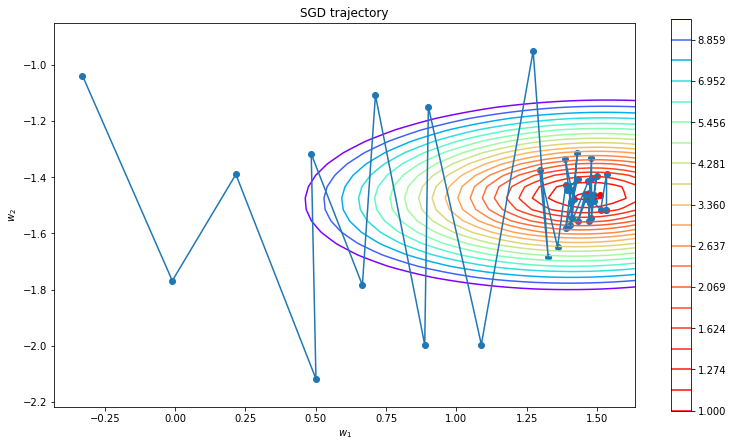

In [49]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Как видно, метод стохастического градиента «бродит» вокруг оптимума. Это объясняется подбором шага градиентного спуска $\eta_k$. Дело в том, что для сходимости стохастического градиентного спуска для последовательности шагов $\eta_k$ должны выполняться [условия Роббинса-Монро](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586):
$$
\sum_{k = 1}^\infty \eta_k = \infty, \qquad \sum_{k = 1}^\infty \eta_k^2 < \infty.
$$
Интуитивно это означает следующее: 
1. последовательность должна расходиться, чтобы метод оптимизации мог добраться до любой точки пространства, 
2. но расходиться не слишком быстро.

Попробуем посмотреть на траектории SGD, последовательность шагов которой удовлетворяет условиям Роббинса-Монро:

In [64]:
w = w_0.copy()
w_list = [w.copy()]
step_size_0 = 1e-2

for i in range(num_steps):
    step_size = step_size_0 / ((i+1)**0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / batch_size
    w_list.append(w.copy())
w_list = np.array(w_list)

In [65]:
w_list

array([[-0.32951336, -1.0393275 ],
       [ 0.04761967, -1.82855491],
       [ 0.20595701, -1.54639309],
       [ 0.37688432, -1.24481131],
       [ 0.51301056, -1.70226007],
       [ 0.53005914, -1.53546154],
       [ 0.61075341, -1.44109061],
       [ 0.6408837 , -1.42545472],
       [ 0.6916021 , -1.43198829],
       [ 0.73684571, -1.49293257],
       [ 0.7935627 , -1.57939534],
       [ 0.84295816, -1.46910783],
       [ 0.87042574, -1.52082957],
       [ 0.8994463 , -1.49886667],
       [ 0.92312896, -1.52098112],
       [ 0.93891571, -1.51146885],
       [ 0.96646443, -1.47002948],
       [ 0.98675852, -1.47988901],
       [ 0.99968755, -1.4803837 ],
       [ 1.0096597 , -1.52527407],
       [ 1.03311301, -1.48511594],
       [ 1.05507577, -1.50817194],
       [ 1.06374263, -1.50752349],
       [ 1.07133745, -1.46863897],
       [ 1.08547625, -1.46207322],
       [ 1.09652921, -1.43350539],
       [ 1.10761719, -1.4311133 ],
       [ 1.12359556, -1.46378805],
       [ 1.13225434,

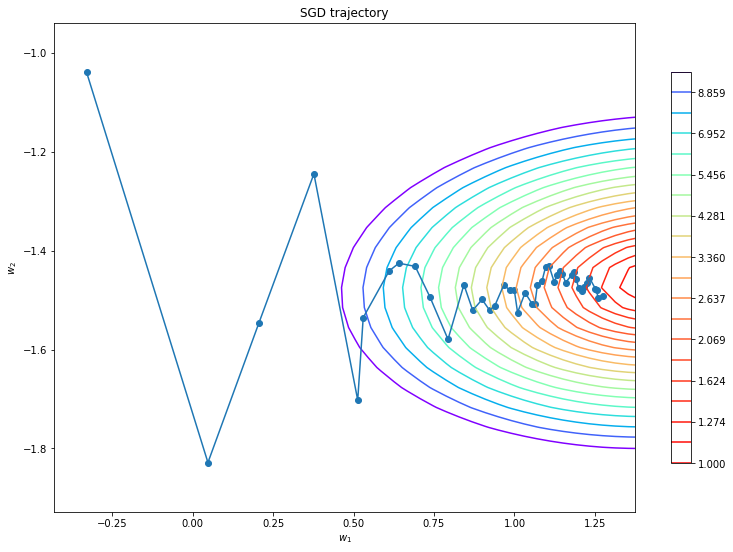

In [66]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
#plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

### Сравнение скоростей сходимости

Последнее, что хотелось бы продемонстрировать — сравнение, насколько быстро достигают оптимума метод полного и стохастического градиентного спуска. Сгенерируем выборку и построим график зависимости функционала от итерации.

In [67]:
# data generation
n_features = 50
n_objects = 1000
num_steps = 200
batch_size = 10

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [70]:
step_size_sgd = 0.01
step_size_gd = 1e-2
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()
residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

for i in range(num_steps):
    step_size = step_size_sgd / ((i+1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w_sgd -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample]) / batch_size
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))
    
    w_gd -= 2 * step_size_gd * np.dot(X.T, np.dot(X, w_gd) - Y) / Y.shape[0]
    residuals_gd.append(np.mean(np.power(np.dot(X, w_gd) - Y, 2)))

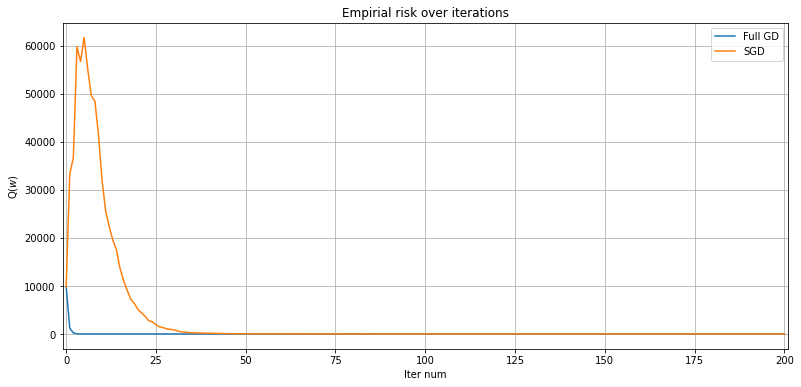

In [71]:
plt.figure(figsize=(13, 6))
plt.plot(range(num_steps+1), residuals_gd, label='Full GD')
plt.plot(range(num_steps+1), residuals_sgd, label='SGD')
plt.title('Empirial risk over iterations')
plt.xlim((-1, num_steps+1))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()

Как видно, GD буквально за несколько итераций оказывается вблизи оптимума, в то время как поведение SGD может быть весьма нестабильным. Как правило, для более сложных моделей наблюдаются ещё большие флуктуации в зависимости качества функционала от итерации при использовании стохастических градиентных методов. Путём подбора величины шага можно добиться лучшей скорости сходимости, и существуют методы, адаптивно подбирающие величину шага (AdaGrad, Adam, RMSProp).

### Linear regression out of the box

Finally, let's take a brief look at implemented versions of Linear Regression from sklearn. The main classes are:

* [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) — classical linear regression (*actially, it is just `scipy.linalg.lstsq` wrapped with sklearn `Predictor` class) __analytical__ solver.
* [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) — Linear regression with L1 regularization.
* [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) — Linear regression with L2 regularization.

To minimize any other error function you are free to use [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) (or wait a few weeks and we will get the great *PyTorch* automatic differentiation engine).

Let's compare the speed of analytical and gradient solutions from the sklearn realizations.

IPython magic `%%time` wrapper will be used.

To measure the quality $R^2$ score will be used. It compares our model (`a`) with one always predicting mean `y`:

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$

`LinearRegression` vs. `Ridge`: __Fight!__



![](img/mortal_combat.jpg)

In [72]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [73]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [74]:
%%time

lr = LinearRegression()
lr.fit(X, Y)
print(f'R2: {lr.score(X, Y)}')

R2: 0.9999685028856975
CPU times: user 19.7 s, sys: 13.1 s, total: 32.8 s
Wall time: 3.37 s


In [75]:
%%time

lr = Ridge(alpha=0.0, solver='sparse_cg')
lr.fit(X, Y)
print(f'R2: {lr.score(X, Y)}')

R2: 0.9999681178003055
CPU times: user 3.34 s, sys: 423 ms, total: 3.76 s
Wall time: 405 ms


### Функции потерь в регрессии

Функционал качества в задачах обучения с учителем обычно задается в виде суммы по объектам выборки:
$$Q(a) = \frac 1 \ell \sum_{i=1}^\ell L(y_i, a(x_i)),$$
где $L(\cdot, \cdot)$ - функция потерь, задающая штраф за разницу между предсказанием и истинным значением целевого признака. Свойства функции потерь:
* $L(y_i, a(x_i)) \geqslant 0$;
* $L(y_i, y_i) = 0$. 

Как отмечалось на первой лекции, функционал качества должен в первую очередь отвечать требованиям заказчика, при этом математические свойства функции потерь могут быть неудобны для оптимизации. 

__Пример:__ если мы не различаем маленькие ошибки (между 0.01 и 0.1 нет особой разницы), но зато не хотим получать большие ошибки, можно использовать следующую функцию потерь:

$$L(y_i, a(x_i)) = [| y_i - a(x_i) | < \varepsilon],$$ $\varepsilon$ - допустимая разница между предсказанием и фактом.


### Среднеквадратичная и средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели, например устойчивость к шумовым объектам. В линейной регрессии Mean Squared Error: $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения. 

Рассмотрим это явление на примере. Выберем один признак, от которого целевой признак (имеющий индекс 15 в матрице X) зависит практически линейно. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимизированная на MSE прямая.

In [76]:
with open('data/data_preprocessed.json') as file:
    X = pd.read_json(file)

In [77]:
X_subset = X[[7, 15]].values
# add two outliers
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]]))

In [88]:
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1])
    lr = LinearRegression()
    #lr = Ridge(alpha=0.0, solver='sparse_cg')
    lr.fit(X_subset[:, 0][:, None], X_subset[:, 1])
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, None])
    plt.plot(grid, line)

Text(0.5, 0, 'x')

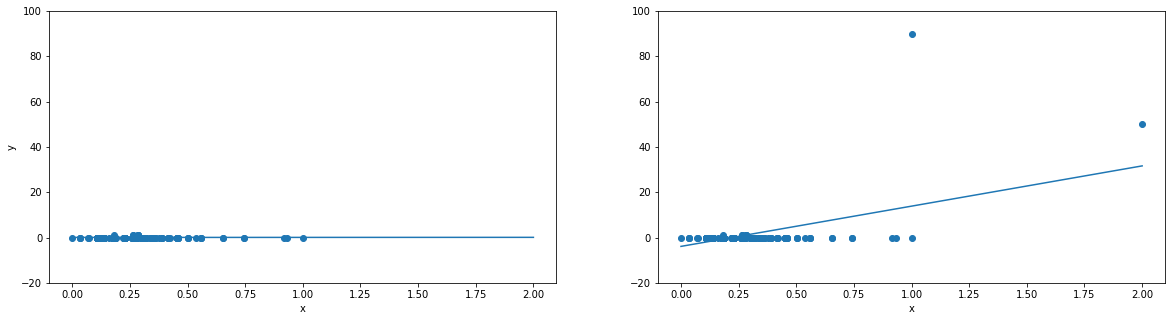

In [89]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE часто используют Mean Absoulte Error:
$$L(y_i, a(x_i)) = |y_i - a(x_i)|$$

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но можно использовать модуль statsmodels

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [82]:
def scatter_points_and_plot_line_MAE(X_subset):
    mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset, columns=["f7", "f15"])) # задаеем зависимость и передаем данные
    res = mod.fit(q=0.5)
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    grid = np.linspace(0, 2, 100)
    plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"])   # визуализируем прямую
    return mod, res

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:207: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0


Text(0.5, 0, 'x')

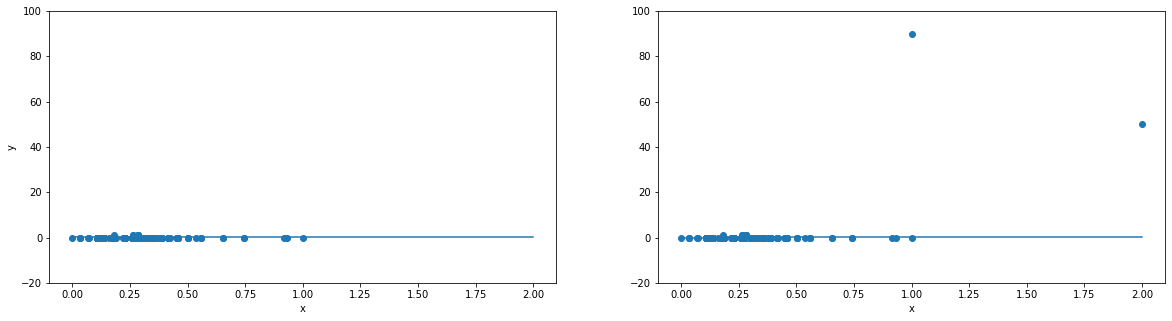

In [83]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая не изменила направление из-за выбросов.

Попробуем добавить больше шумовых объектов:

In [84]:
X_subset_modified_twice = np.vstack((
    X_subset_modified, 
    np.random.randint(5, size=60).reshape(-1, 2) * [1, 30],
))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:207: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0


Text(0.5, 0, 'x')

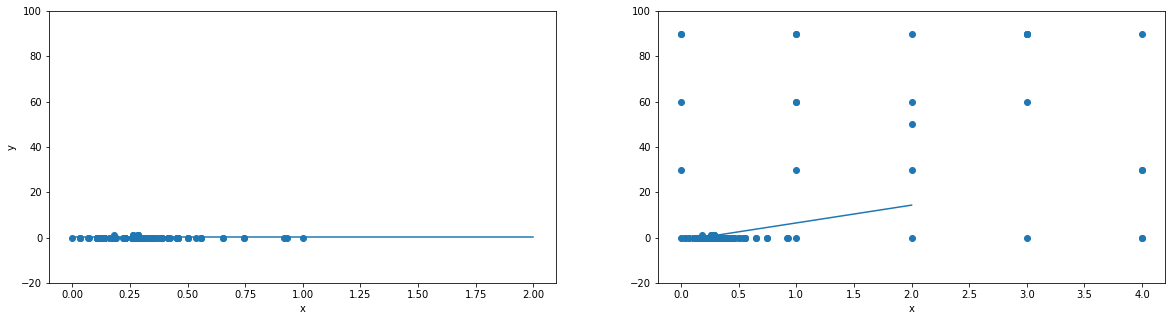

In [85]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.

## Мультиколлинеарность и регуляризация

In [1]:
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#### Решение задачи МНК

In [2]:
def my_linear_regression(X_train, Y_train):
    return np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [3]:
def predict(X, w):
    return np.dot(X, w)

#### Загрузим датасет

https://habrahabr.ru/post/206306/

In [7]:
data = pd.read_csv('data/energy_efficiency.csv')

In [8]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


#### Посмотрим на скоррелированность данных

In [9]:
data.corr()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
X1,1.000000e+00,-9.919015e-01,-2.037817e-01,-8.688234e-01,8.277473e-01,0.000000,1.283986e-17,1.764620e-17,0.622272,0.634339
X2,-9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,-8.581477e-01,0.000000,1.318356e-16,-3.558613e-16,-0.658120,-0.672999
X3,-2.037817e-01,1.955016e-01,1.000000e+00,-2.923165e-01,2.809757e-01,0.000000,-7.969726e-19,0.000000e+00,0.455671,0.427117
X4,-8.688234e-01,8.807195e-01,-2.923165e-01,1.000000e+00,-9.725122e-01,0.000000,-1.381805e-16,-1.079129e-16,-0.861828,-0.862547
X5,8.277473e-01,-8.581477e-01,2.809757e-01,-9.725122e-01,1.000000e+00,0.000000,1.861418e-18,0.000000e+00,0.889430,0.895785
X6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,-0.002587,0.014290
X7,1.283986e-17,1.318356e-16,-7.969726e-19,-1.381805e-16,1.861418e-18,0.000000,1.000000e+00,2.129642e-01,0.269842,0.207505
X8,1.764620e-17,-3.558613e-16,0.000000e+00,-1.079129e-16,0.000000e+00,0.000000,2.129642e-01,1.000000e+00,0.087368,0.050525
Y1,6.222719e-01,-6.581199e-01,4.556714e-01,-8.618281e-01,8.894305e-01,-0.002587,2.698417e-01,8.736846e-02,1.000000,0.975862
Y2,6.343391e-01,-6.729989e-01,4.271170e-01,-8.625466e-01,8.957852e-01,0.014290,2.075050e-01,5.052512e-02,0.975862,1.000000


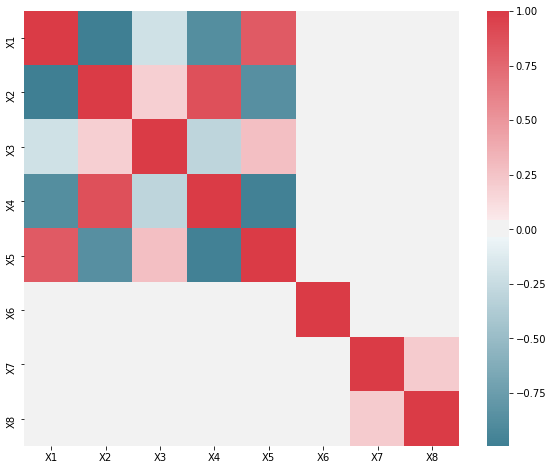

In [96]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.drop(['Y1','Y2'], axis=1).corr()
sns.heatmap(corr, square=True, ax=ax, cmap=sns.diverging_palette(220, 10, as_cmap=True))

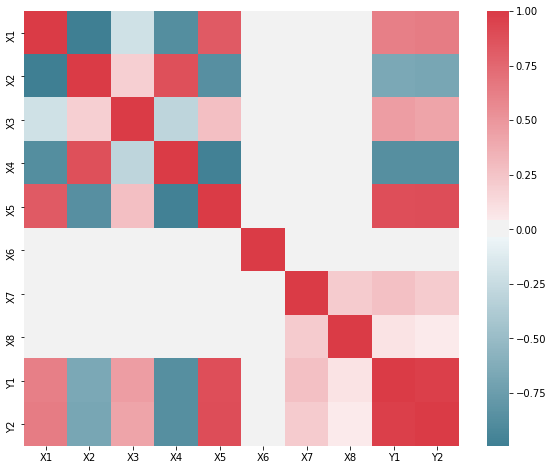

In [97]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, square=True, ax=ax, cmap=sns.diverging_palette(220, 10, as_cmap=True))

Видим, что x1 скоррелирован с x2, а x4 с x5. Из-за этого матрица $X^{T}*X$ необратима.

#### Посмотрим как на таких данных отработает наша линейная регрессия

Разобьем выборку на train и test

In [98]:
X = data.drop(['Y1','Y2'], axis=1)
y = data['Y1']

In [99]:
X.shape, y.shape

((768, 8), (768,))

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучим регрессию и посмотрим на качество

In [101]:
w = my_linear_regression(X_train, y_train)

In [102]:
y_train_pred = predict(X_train, w)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train R2: ", r2_score(y_train, y_train_pred))

Train MSE:  10319.5446343782
Train R2:  -101.25073919229212


In [103]:
y_test_pred = predict(X_test, w)
print("Test MSE: ", mean_squared_error(y_test, y_test_pred))
print("Test R2: ", r2_score(y_test, y_test_pred))

Test MSE:  10782.512187136432
Test R2:  -102.44682869203848


Как-то не очень

#### Попробуем убрать скоррелированные признаки

In [104]:
X = data.drop(['X1','X4', 'Y1','Y2'], axis=1)
y = data['Y1']

In [105]:
X.shape, y.shape

((768, 6), (768,))

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучим регрессию и посмотрим на качество

In [107]:
w = my_linear_regression(X_train, y_train)

In [108]:
y_train_pred = predict(X_train, w)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train R2: ", r2_score(y_train, y_train_pred))

Train MSE:  9.8519587007591
Train R2:  0.9023823147885197


In [109]:
y_test_pred = predict(X_test, w)
print("Test MSE: ", mean_squared_error(y_test, y_test_pred))
print("Test R2: ", r2_score(y_test, y_test_pred))

Test MSE:  11.387213360639413
Test R2:  0.8907517015187723


Юху! Получили алгоритм с хорошим качеством

#### Реализуем линейную регрессию с L2 регуляризацией

In [110]:
def my_linear_regression(X_train, Y_train, l2=0):
    return np.linalg.inv(X_train.T.dot(X_train) + l2*np.eye(X_train.shape[1])).dot(X_train.T).dot(y_train)

Обучим регрессию с регуляризацией и посмотрим на качество

In [111]:
X = data.drop(['Y1','Y2'], axis=1)
y = data['Y1']

In [112]:
X.shape, y.shape

((768, 8), (768,))

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
w = my_linear_regression(X_train, y_train, l2=0.001)

In [115]:
y_train_pred = predict(X_train, w)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train R2: ", r2_score(y_train, y_train_pred))

Train MSE:  8.566900363926832
Train R2:  0.9151152569387557


In [116]:
y_test_pred = predict(X_test, w)
print("Test MSE: ", mean_squared_error(y_test, y_test_pred))
print("Test R2: ", r2_score(y_test, y_test_pred))

Test MSE:  9.464056762981176
Test R2:  0.9092023601086374


Этого же эффекта(отсутствие переобучения) добились добавив регуляризацию